# **Khởi tạo**

**Import thư viện**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, LSTM, Dense, Flatten, Reshape
import os

**Đọc và xử lý dữ liệu**

In [2]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data = data[['Price']]

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)
    data = data.reset_index()['Price']

    return data

**Xây dựng mô hình**

In [3]:
# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
# Hàm Create Dataset
def create_dataset(dataset, seq_size=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        dataX.append(window)
        dataY.append(dataset[i + seq_size, 0])
    return np.array(dataX), np.array(dataY)

In [5]:
def CNN_LSTM_prediction(name, data, train_ratio=0.7, days=30):

    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(np.array(data).reshape(-1,1))

    # Chia train, test
    train_size = int(train_ratio * len(data))
    test_size = len(data) - train_size
    train_data = data[:train_size]
    test_data = data[train_size:train_size+test_size]
    
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    seq_size = 100
    X_train, y_train = create_dataset(train_data, seq_size)
    X_test, y_test = create_dataset(test_data, seq_size)
    
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  
    # Xây dựng mô hình CNN-LSTM
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=50, return_sequences=True, activation='relu'))
    model.add(Dropout(0.2))
    # model.add(LSTM(units=20, return_sequences=True))
    # model.add(Dropout(0.2))
    model.add(Flatten())
    # model.add(Dense(32))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # model.summary()
    
    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    
    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    # Chuẩn hóa dữ liệu y_test
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Đánh giá độ chính xác thuật toán bằng RMSE
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Testing RMSE:', test_rmse)

    # Đánh giá độ chính xác thuật toán bằng MAE
    test_mae = mean_absolute_error(y_test, y_pred)
    print('Testing MAE:', test_mae)
    
    # Đánh giá độ chính xác thuật toán bằng MAPE
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    print('Testing MAPE:', test_mape)

    # Dự báo các ngày tiếp theo
    x_input = test_data[-seq_size:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < days:
        if len(temp_input) > seq_size:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, seq_size, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, seq_size, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
    
    # Vẽ hình
    plt.title('CNN-LSTM {} ({})'.format(train_ratio, name))
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+seq_size+1, stop=train_size+test_size, step=1)
    plt.plot(test_data_index,(y_pred))
    prediect_data_index = pd.RangeIndex(start=len(data)-1, stop=len(data)+days-1, step=1)
    plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
    plt.legend(['Train','Test','Predict','Predict'+str(days)+'days'])
    plt.show()


# **BIDV**

In [6]:
data = read_file("../Dataset/BID Historical Data.csv");
name = 'BIDV'

## **30 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Testing RMSE: 2427.2361028568903
Testing MAE: 2121.139386953552
Testing MAPE: 4.758042780490189


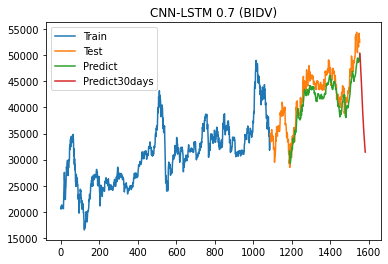

In [7]:
CNN_LSTM_prediction(name, data, 0.7)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 1923.4110109497365
Testing MAE: 1608.2834263392858
Testing MAPE: 3.467657649512205


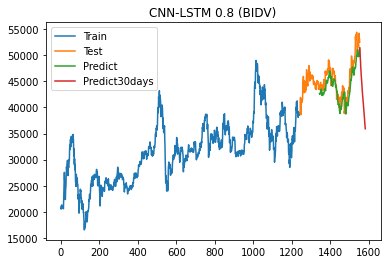

In [8]:
CNN_LSTM_prediction(name, data, 0.8)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Testing RMSE: 1570.4996887219972
Testing MAE: 1200.6980823863637
Testing MAPE: 2.3393461724189764


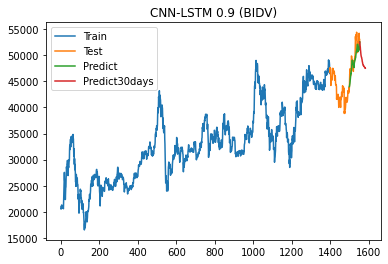

In [9]:
CNN_LSTM_prediction(name, data, 0.9)

## **60 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Testing RMSE: 1914.212300652363
Testing MAE: 1588.8513970713798
Testing MAPE: 3.618520235303958


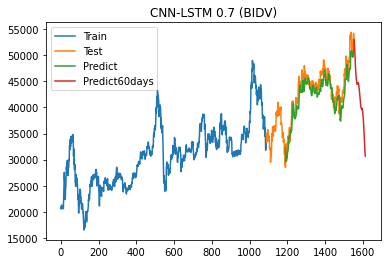

In [10]:
CNN_LSTM_prediction(name, data, 0.7, 60)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 1463.6511842463842
Testing MAE: 1153.5922061011906
Testing MAPE: 2.5173890607799962


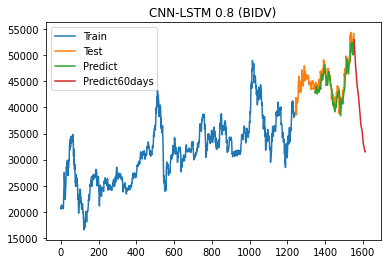

In [11]:
CNN_LSTM_prediction(name, data, 0.8, 60)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Testing RMSE: 1518.4718042669863
Testing MAE: 1178.6568892045457
Testing MAPE: 2.3132395791025497


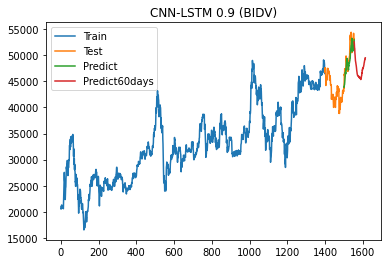

In [12]:
CNN_LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Testing RMSE: 1532.616352993389
Testing MAE: 1177.2225815403006
Testing MAPE: 2.739937756906142


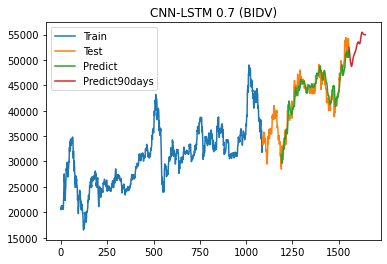

In [13]:
CNN_LSTM_prediction(name, data, 0.7, 90)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Testing RMSE: 1580.379608601876
Testing MAE: 1162.2348028273811
Testing MAPE: 2.4774642032369645


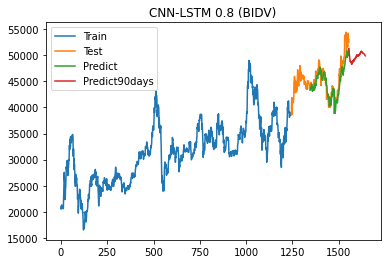

In [14]:
CNN_LSTM_prediction(name, data, 0.8, 90)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Testing RMSE: 1850.9287553721483
Testing MAE: 1556.6191761363636
Testing MAPE: 3.081995456762217


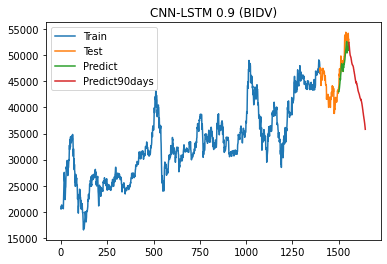

In [15]:
CNN_LSTM_prediction(name, data, 0.9, 90)

# **VCB**

In [16]:
data = read_file("../Dataset/VCB Historical Data.csv");
name = 'VCB'

## **30 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Testing RMSE: 2887.481485221906
Testing MAE: 2191.178961748634
Testing MAPE: 2.4665488757842713


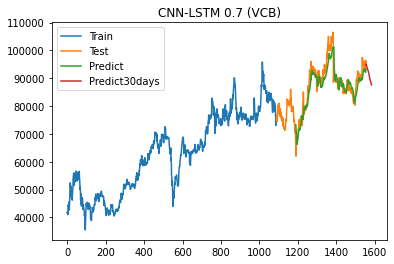

In [17]:
CNN_LSTM_prediction(name, data, 0.7)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 3460.1274021573054
Testing MAE: 2555.875037202381
Testing MAPE: 2.701381774026058


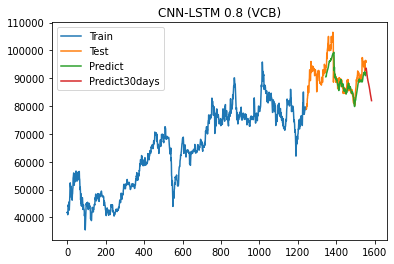

In [18]:
CNN_LSTM_prediction(name, data, 0.8)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Testing RMSE: 2412.453223857137
Testing MAE: 1871.7774147727262
Testing MAPE: 2.029323856841413


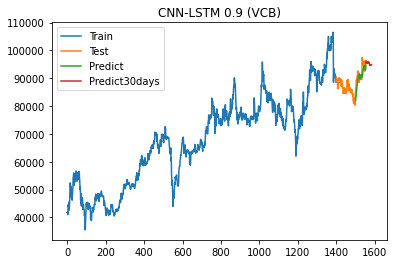

In [19]:
CNN_LSTM_prediction(name, data, 0.9)

## **60 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Testing RMSE: 2881.659366179884
Testing MAE: 2237.1002604166665
Testing MAPE: 2.529676323165553


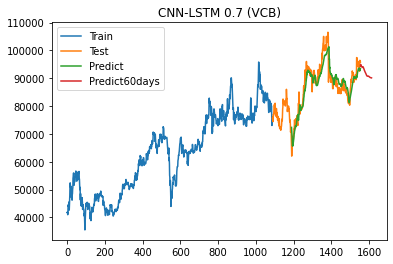

In [20]:
CNN_LSTM_prediction(name, data, 0.7, 60)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 4002.819888463041
Testing MAE: 3005.5247395833335
Testing MAPE: 3.169173352078467


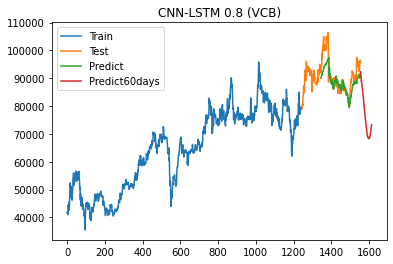

In [21]:
CNN_LSTM_prediction(name, data, 0.8, 60)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 2096.2043507172766
Testing MAE: 1673.4970170454535
Testing MAPE: 1.8146029520778868


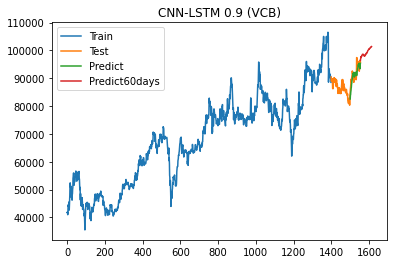

In [22]:
CNN_LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Testing RMSE: 3215.455676756197
Testing MAE: 2593.2752945696716
Testing MAPE: 2.9115781323019942


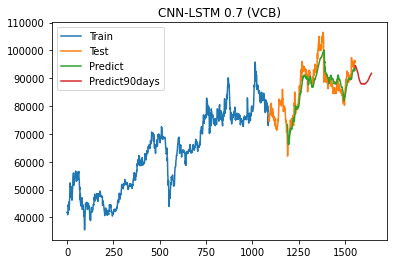

In [23]:
CNN_LSTM_prediction(name, data, 0.7, 90)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Testing RMSE: 4073.9607924892443
Testing MAE: 2934.2893973214286
Testing MAPE: 3.077414880986685


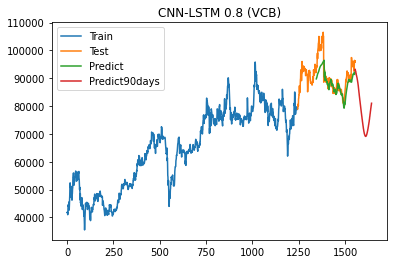

In [24]:
CNN_LSTM_prediction(name, data, 0.8, 90)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 3171.7707851060727
Testing MAE: 2554.4948863636355
Testing MAPE: 2.7624236722530475


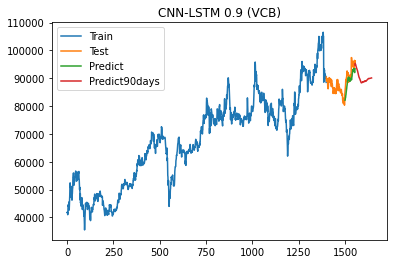

In [25]:
CNN_LSTM_prediction(name, data, 0.9, 90)

# **MBB**

In [26]:
data = read_file("../Dataset/MBB Historical Data.csv");
name = 'MBB'

## **30 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Testing RMSE: 1958.8564324557613
Testing MAE: 1693.944556864755
Testing MAPE: 9.360409673366252


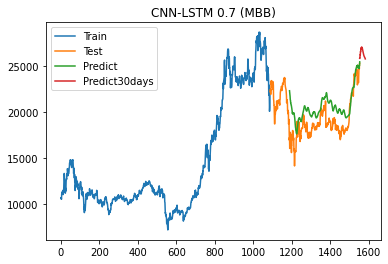

In [27]:
CNN_LSTM_prediction(name, data, 0.7)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 1155.270122136077
Testing MAE: 994.1667447916677
Testing MAPE: 5.193076207838201


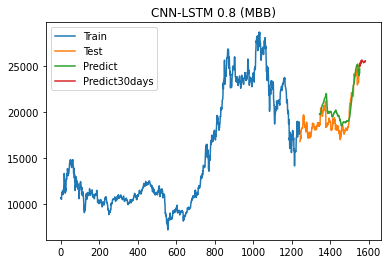

In [28]:
CNN_LSTM_prediction(name, data, 0.8)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Testing RMSE: 778.8663182015828
Testing MAE: 613.8610085227273
Testing MAPE: 2.7122376911892125


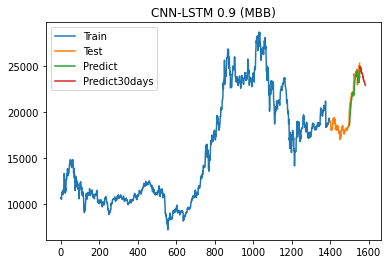

In [29]:
CNN_LSTM_prediction(name, data, 0.9)

## **60 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 1877.4807797462402
Testing MAE: 1684.9784270406428
Testing MAPE: 9.275080577688609


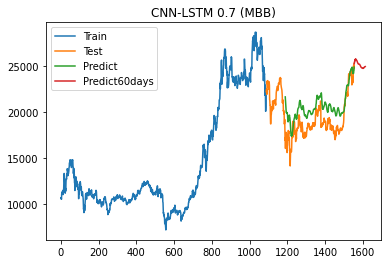

In [30]:
CNN_LSTM_prediction(name, data, 0.7, 60)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 982.4390079087732
Testing MAE: 839.2201488095247
Testing MAPE: 4.373876964144805


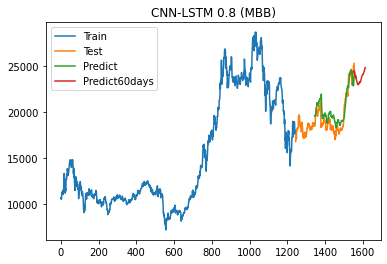

In [31]:
CNN_LSTM_prediction(name, data, 0.8, 60)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing RMSE: 683.0823592305231
Testing MAE: 529.0262073863636
Testing MAPE: 2.3488748335258625


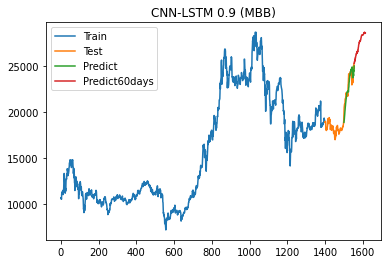

In [32]:
CNN_LSTM_prediction(name, data, 0.9, 60)

## **90 ngày**

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 1900.3683257461373
Testing MAE: 1698.2413998463119
Testing MAPE: 9.378858061098173


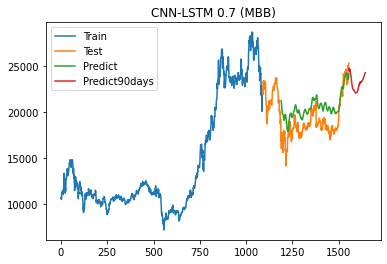

In [33]:
CNN_LSTM_prediction(name, data, 0.7, 90)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 756.329676283163
Testing MAE: 597.3817745535722
Testing MAPE: 3.062719480247749


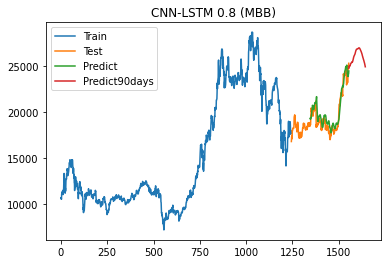

In [34]:
CNN_LSTM_prediction(name, data, 0.8, 90)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 996.5359355689413
Testing MAE: 840.3227982954542
Testing MAPE: 3.6975056317813495


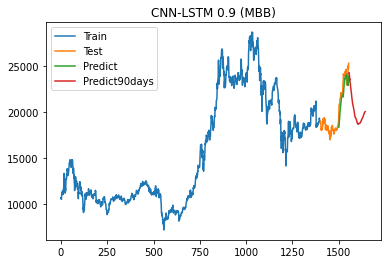

In [35]:
CNN_LSTM_prediction(name, data, 0.9, 90)